***Importing All Necessary Library***

In [1]:
import os
import numpy as np
import random
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU
from tqdm import tqdm
from tensorflow.keras.models import load_model
from skimage.io import imshow
import json


***Pre-processing and Loading data from Dataset***

In [2]:

# def process_and_load_data(image_dir, mask_dir, img_height, img_width):

#     image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
#     num_samples = len(image_files)
    
#     X = np.zeros((num_samples, img_height, img_width, 3), dtype=np.uint8)
#     Y = np.zeros((num_samples, img_height, img_width, 1), dtype=bool)

#     for i, image_file in tqdm(enumerate(image_files), total=num_samples):
#         img_path = os.path.join(image_dir, image_file)  # Path to the input image
#         mask_path = os.path.join(mask_dir, image_file.replace('.jpg', '.png'))  # Path to the corresponding mask

#         img = Image.open(img_path).convert('RGB')  # Ensure the image has 3 channels (RGB)
#         img = resize(np.array(img), (img_height, img_width), mode='constant', preserve_range=True)  # Resize the image
#         mask = resize(np.array(Image.open(mask_path).convert('L')), (img_height, img_width, 1), mode='constant', preserve_range=True)  # Resize and convert the mask

#         X[i] = img
#         Y[i] = mask > 0  # Binarize the mask

#     return X, Y


In [3]:
# IMG_HEIGHT = 128
# IMG_WIDTH = 128
# train_image_dir = "/kaggle/input/plant-seg/plantsegv2/images/train"
# train_mask_dir = "/kaggle/input/plant-seg/plantsegv2/annotations/train"

# val_image_dir = "/kaggle/input/plant-seg/plantsegv2/images/val"
# val_mask_dir = "/kaggle/input/plant-seg/plantsegv2/annotations/val"

# test_image_dir = "/kaggle/input/plant-seg/plantsegv2/images/test"
# test_mask_dir = "/kaggle/input/plant-seg/plantsegv2/annotations/test"
# print("Processing training data")
# X_train, Y_train = process_and_load_data(train_image_dir, train_mask_dir, IMG_HEIGHT, IMG_WIDTH)

# print("Processing validation data")
# X_val, Y_val = process_and_load_data(val_image_dir, val_mask_dir, IMG_HEIGHT, IMG_WIDTH)

# print("Processing test data")
# X_test, Y_test = process_and_load_data(test_image_dir, test_mask_dir, IMG_HEIGHT, IMG_WIDTH)


***Saving and Loading Processed dataset***

In [4]:
# # Save datasets
# np.savez_compressed('/kaggle/working/dataset.npz',
#                     X_train=X_train, Y_train=Y_train,
#                     X_val=X_val, Y_val=Y_val,
#                     X_test=X_test, Y_test=Y_test)
# print("Datasets saved successfully.")


In [5]:
data = np.load('/kaggle/input/dataset-1/dataset.npz')
X_train = data['X_train']
Y_train = data['Y_train']
X_val = data['X_val']
Y_val = data['Y_val']
X_test = data['X_test']
Y_test = data['Y_test']

print("Datasets loaded successfully.")


Datasets loaded successfully.


In [6]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (7916, 128, 128, 3)
Y_train shape: (7916, 128, 128, 1)
X_test shape: (2295, 128, 128, 3)
Y_test shape: (2295, 128, 128, 1)


***Visualizing Sample Image From Training,Testing & Validation***

Sample images from training data:


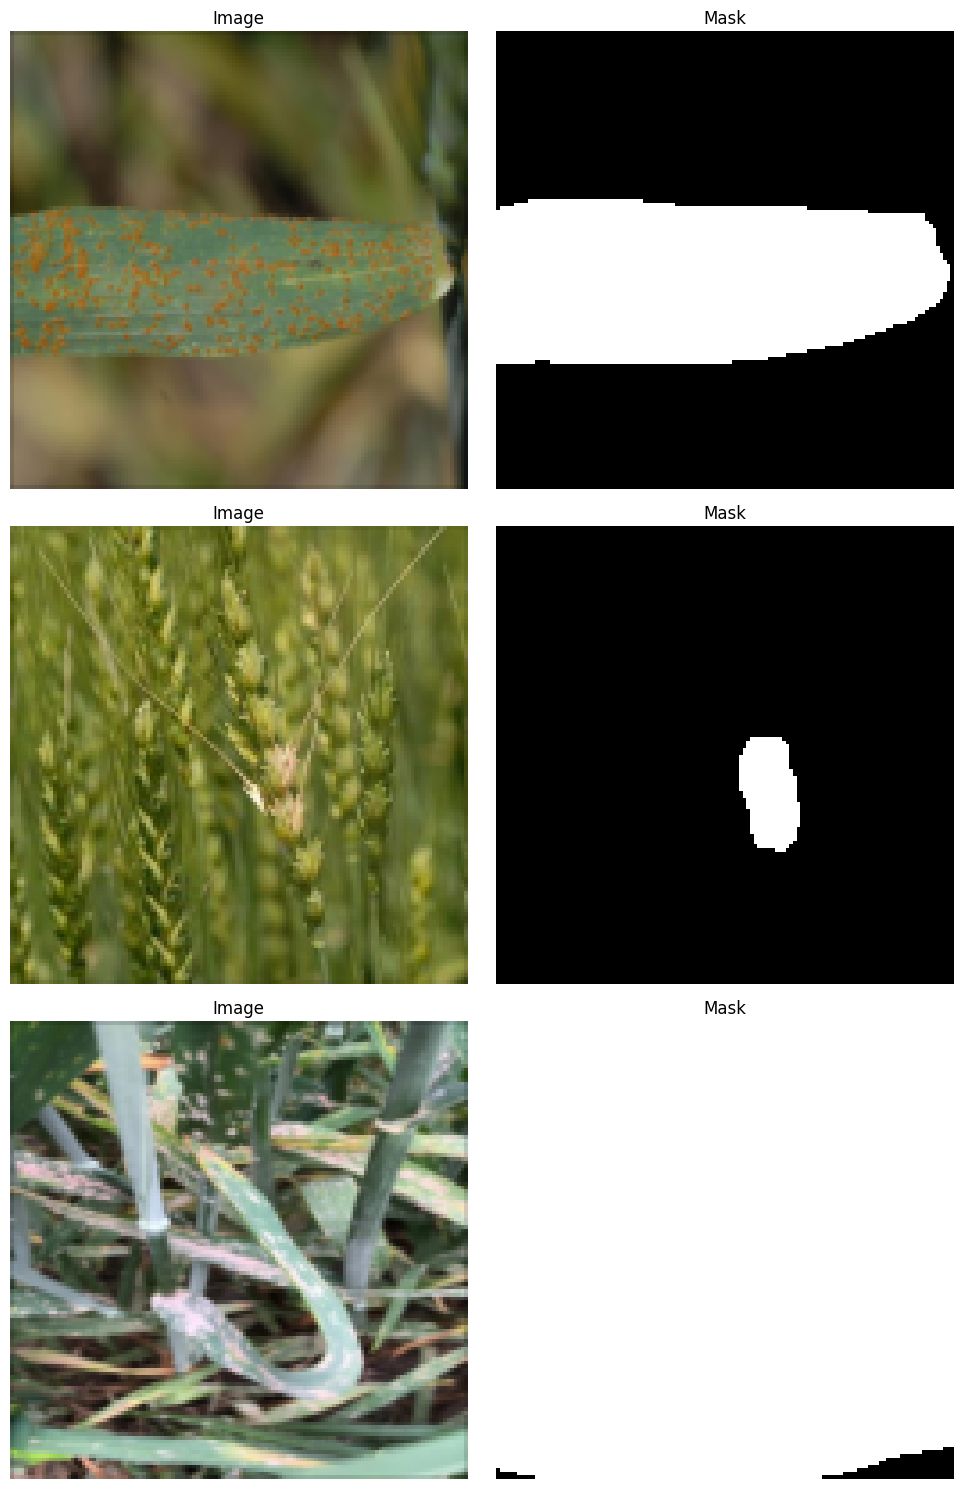

Sample images from validation data:


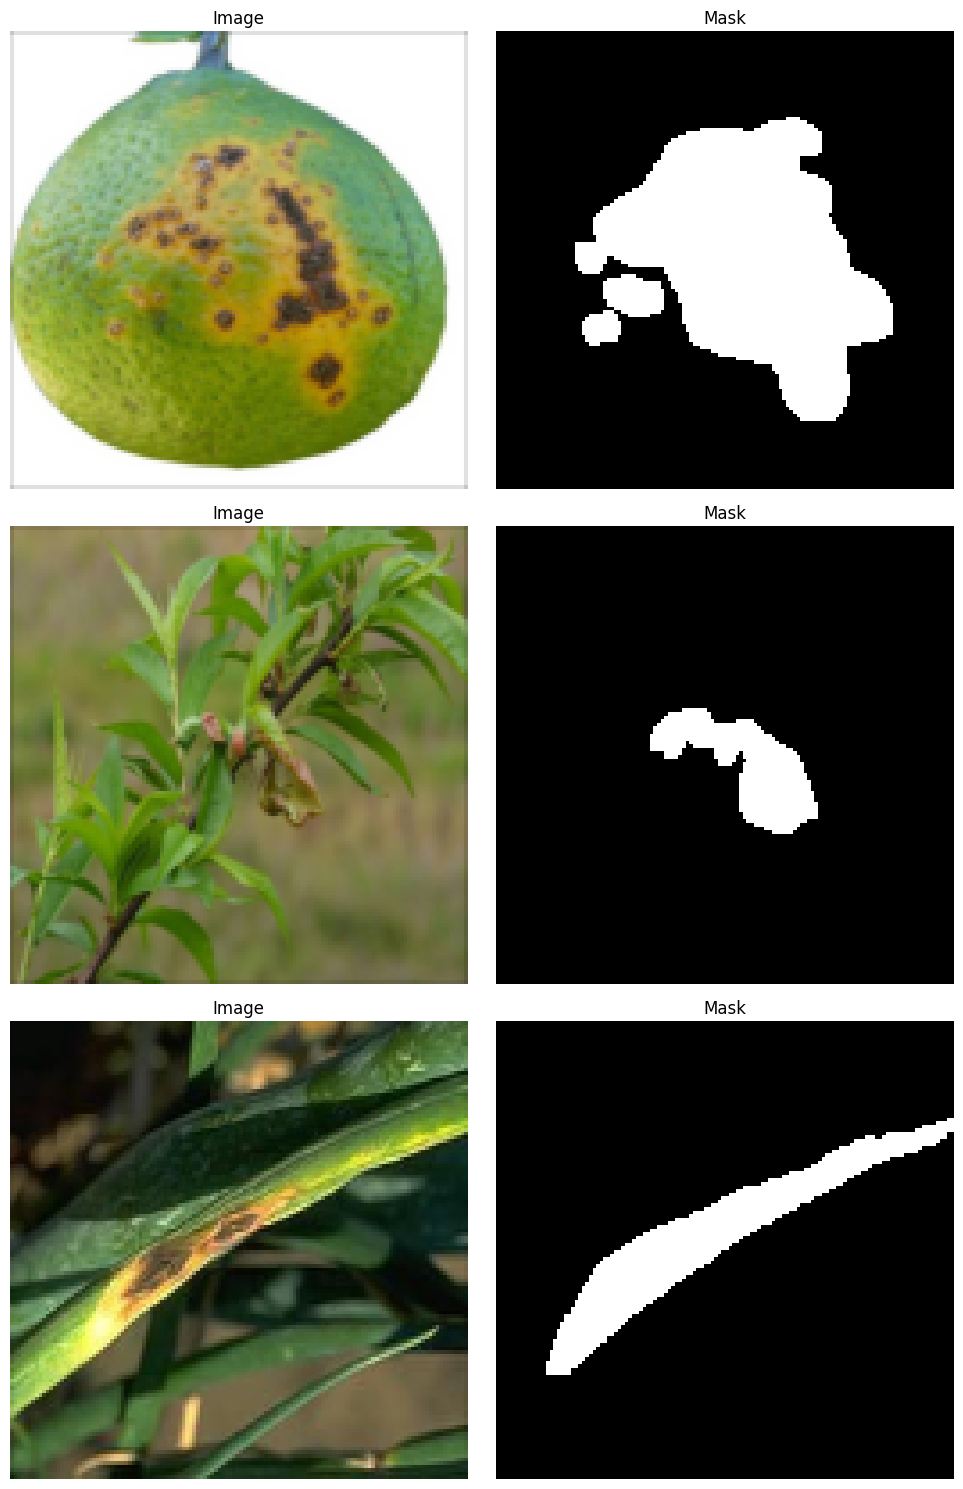

Sample images from testing data:


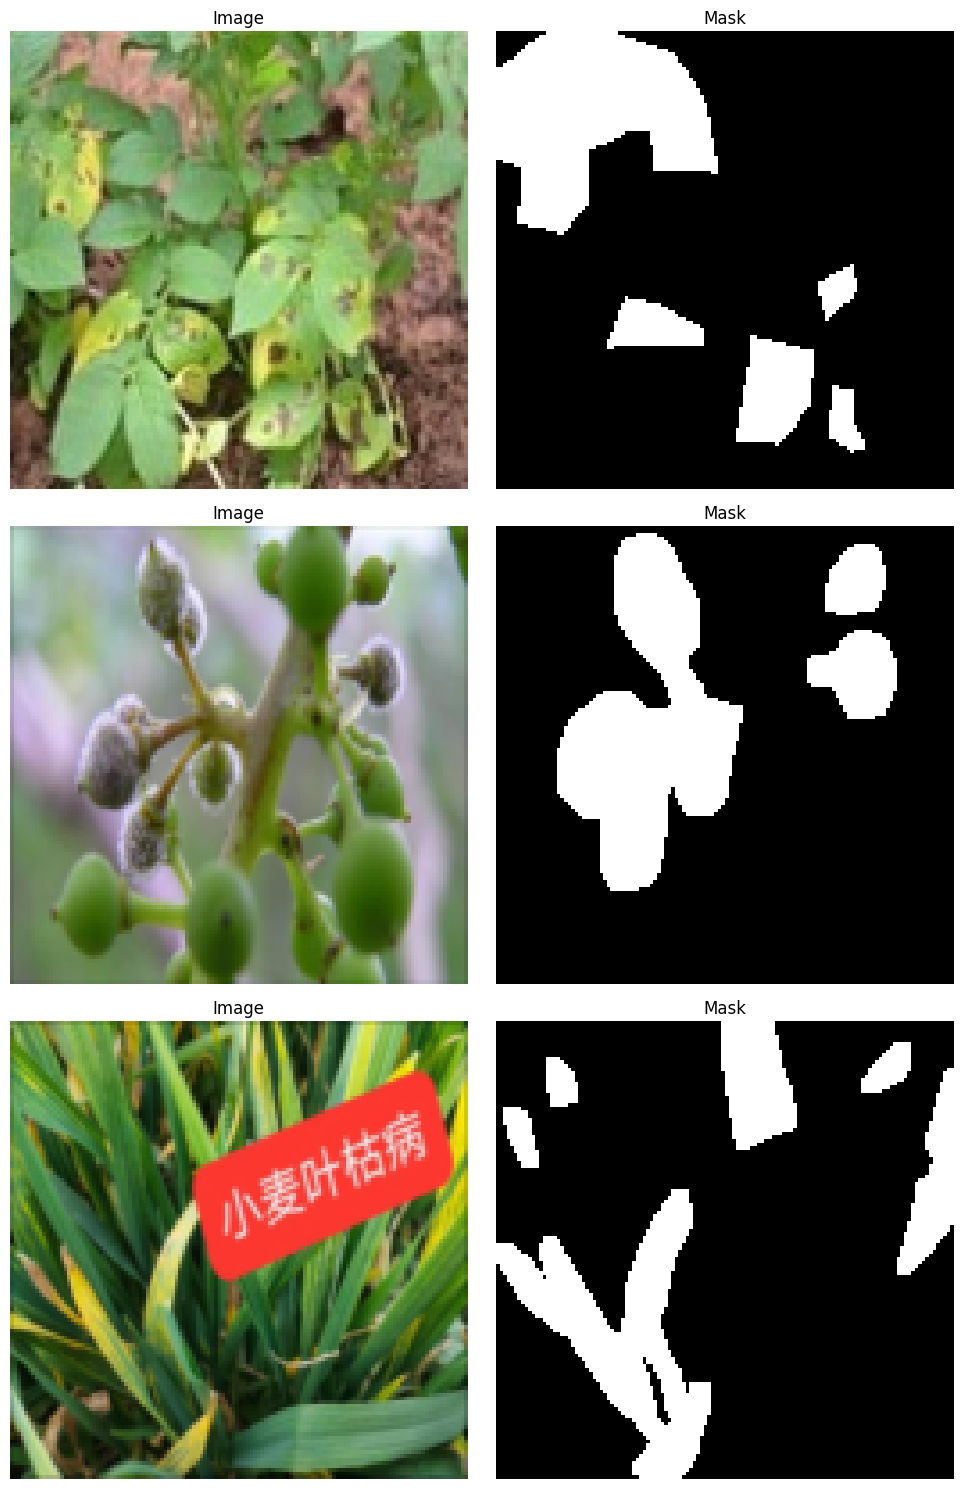

In [7]:
def plot_samples(images, masks, num_samples=3):
    if num_samples > len(images):
        num_samples = len(images)  # Adjust num_samples if fewer images are available
    
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))  # Adjust the size as needed

    for i in range(num_samples):
        # Check if there's only one row (num_samples == 1), axs array is not 2D
        img_plot = axs[i, 0] if num_samples > 1 else axs[0]
        mask_plot = axs[i, 1] if num_samples > 1 else axs[1]
        
        # Display image
        img_plot.imshow(images[i])
        img_plot.set_title('Image')
        img_plot.axis('off')
        
        # Display mask
        mask_plot.imshow(masks[i].squeeze(), cmap='gray')  # Ensure mask is squeezed in case it's 3D
        mask_plot.set_title('Mask')
        mask_plot.axis('off')

    plt.tight_layout()
    plt.show()
print("Sample images from training data:")
plot_samples(X_train, Y_train)

print("Sample images from validation data:")
plot_samples(X_val, Y_val)

print("Sample images from testing data:")
plot_samples(X_test, Y_test)


***Building U_NET Model***

In [8]:
# Define the U-Net model
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3 
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    s = inputs

    # Contracting Path (Encoder)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(s)  # First convolutional layer
    c1 = Dropout(0.1)(c1)  # Add dropout for regularization
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)  # Second convolutional layer
    p1 = MaxPooling2D((2, 2))(c1)  # Downsample using max pooling

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)  # Convolutional layer with 128 filters
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)  # Convolutional layer with 256 filters
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)  # Convolutional layer with 512 filters
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)  # Bottleneck layer
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding Path (Decoder)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)  # Upsample and reduce filters
    u6 = concatenate([u6, c4])  # Concatenate with the corresponding encoder layer
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Final output layer with a sigmoid activation

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])  # Compile the model

    return model

 


***Training U_NET Model***

Epoch 1/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6930 - loss: 1.5627 - mean_io_u: 0.2827
Epoch 1: val_loss improved from inf to 0.56223, saving model to plantseg_unet.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 108s 322ms/step - accuracy: 0.6931 - loss: 1.5596 - mean_io_u: 0.2826 - val_accuracy: 0.7380 - val_loss: 0.5622 - val_mean_io_u: 0.3690
Epoch 2/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7271 - loss: 0.5550 - mean_io_u: 0.2841
Epoch 2: val_loss improved from 0.56223 to 0.51504, saving model to plantseg_unet.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 205ms/step - accuracy: 0.7271 - loss: 0.5549 - mean_io_u: 0.2840 - val_accuracy: 0.7567 - val_loss: 0.5150 - val_mean_io_u: 0.3690
Epoch 3/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7418 - loss: 0.5257 - mean_io_u: 0.2843
Epoch 3: val_loss improved from 0.51504 to 0.49492, saving model to plantseg_unet.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 205ms/step - accuracy: 0.7418 - loss: 0.5257 - mean_io

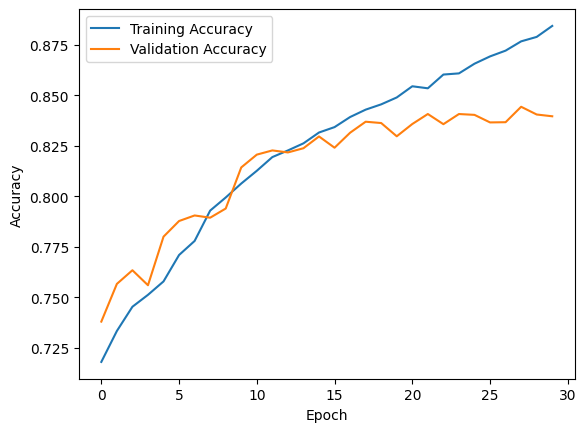

''

In [9]:
# Callbacks for model saving and early stopping
checkpointer = ModelCheckpoint('plantseg_unet.keras', verbose=1, save_best_only=True)
# early_stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Instantiate and compile the model
model = unet_model()


# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=32,
    callbacks=[checkpointer]
)
history_path = '/kaggle/working/training_history.json'
with open(history_path, 'w') as f:
    json.dump(history.history, f)


# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on validation and test data

_

In [10]:
model_path = '/kaggle/input/u_net_model_final/keras/default/1/plantseg_unet_model_1_new.h5'

# Load the model using Keras
model = load_model(model_path)
print("Model loaded successfully.")


Model loaded successfully.


In [11]:
history_path = '/kaggle/working/training_history.json'

# Load the history
with open(history_path, 'r') as f:
    history = json.load(f)

# Now `history` is a dictionary containing the history data


In [12]:
# import matplotlib.pyplot as plt

# # Plot training history for accuracy
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot training history for loss
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Evaluate the model on the validation data and capture all metrics in a list
# val_results = model.evaluate(X_val, Y_val, verbose=1)
# print("Validation Results:")
# print(f"Validation Loss: {val_results[0]:.4f}, Validation Accuracy: {val_results[1]:.4f}")

# # Assuming Y_test is corrected
# test_results = model.evaluate(X_test, Y_test, verbose=1)
# print("Test Results:")
# print(f"Test Loss: {test_results[0]:.4f}, Test Accuracy: {test_results[1]:.4f}")
# # Similarly, for more metrics:
# # print(f"Some Other Metric: {test_results[2]:.4f}")




Saving the model

In [13]:
# # Save the trained model
# model.save('plantseg_unet_model_1_new.h5')
# print("Model saved as plantseg_unet_model_1_new.h5")



***Evaluating Model Performance***

In [14]:
# # Evaluate the model on the validation dataset
# val_results = model.evaluate(X_val, Y_val, verbose=1)
# print("Validation Results:")
# # Print each metric with its name
# for metric, value in zip(model.metrics_names, val_results):
#     print(f"{metric.capitalize()}: {value:.4f}")




In [15]:
# # Evaluate the model on the validation dataset
# # Evaluate the model on the test dataset
# test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
# print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


In [16]:
# model_path = '/kaggle/input/u_net_model_final/keras/default/1/plantseg_unet_model_1_new.h5'

# # Load the model using Keras
# model = load_model(model_path)
# print("Model loaded successfully.")


In [17]:
# print("Shape of X_test:", X_test.shape)
# print("Shape of predicted masks before reshaping:", pred_mask.shape)
# print("Shape of Y_test:", Y_test.shape)


In [18]:
# def test_thresholds(X, Y, model, thresholds):
#     for threshold in thresholds:
#         pred_mask = model.predict(X)
#         pred_mask = (pred_mask > threshold).astype(np.uint8)
#         true_mask = Y.squeeze()
#         pixel_accuracy, mean_iou, mean_dice = compute_metrics(pred_mask.squeeze(), true_mask, num_classes=1)
#         print(f"Threshold: {threshold:.2f} - Pixel Accuracy: {pixel_accuracy:.4f}, Mean IoU: {mean_iou:.4f}, Mean Dice: {mean_dice:.4f}")

# thresholds = np.arange(0.3, 0.7, 0.05)
# test_thresholds(X_test, Y_test, model, thresholds)


In [19]:
# def compute_metrics(pred_mask, true_mask, num_classes):
#     # Ensure the masks are flattened (1D)
#     pred_mask = pred_mask.flatten()
#     true_mask = true_mask.flatten()

#     # Pixel Accuracy
#     pixel_accuracy = np.sum(pred_mask == true_mask) / len(true_mask)

#     # IoU (Intersection over Union)
#     iou_list = []
#     for i in range(num_classes):
#         # Calculate IoU for each class
#         pred_class = (pred_mask == i)
#         true_class = (true_mask == i)

#         intersection = np.sum(pred_class & true_class)
#         union = np.sum(pred_class | true_class)

#         iou = intersection / (union + 1e-6)  # Add a small epsilon to prevent division by zero
#         iou_list.append(iou)

#     mean_iou = np.mean(iou_list)

#     # Dice Coefficient
#     dice_list = []
#     for i in range(num_classes):
#         pred_class = (pred_mask == i)
#         true_class = (true_mask == i)

#         intersection = np.sum(pred_class & true_class)
#         dice = (2 * intersection) / (np.sum(pred_class) + np.sum(true_class) + 1e-6)
#         dice_list.append(dice)

#     mean_dice = np.mean(dice_list)

#     return pixel_accuracy, mean_iou, mean_dice

# # Example usage with predicted and true masks
# num_classes = 1  # Example: for binary segmentation, num_classes would be 2 (background, foreground)


# # Assuming true_mask comes from Y_test which might not be squeezed properly or pred_mask isn't correctly shaped
# # Verify and reshape the prediction mask to match the ground truth mask dimensions
# pred_mask = model.predict(X_test)  # Predict segmentation for the test images
# pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Convert probabilities to binary mask

# # Ensure pred_mask is reshaped to match Y_test if necessary
# pred_mask = pred_mask.reshape(Y_test.shape)

# # Now both should be of the same shape, ensuring the computation doesn't throw an error
# true_mask = Y_test.squeeze()  # Adjust this depending on the specific shape of Y_test

# # Compute evaluation metrics
# pixel_accuracy, mean_iou, mean_dice = compute_metrics(pred_mask, true_mask, num_classes=1)

# print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
# print(f"Mean IoU: {mean_iou:.4f}")
# print(f"Mean Dice Coefficient: {mean_dice:.4f}")


In [20]:
# import matplotlib.pyplot as plt

# # Example data, replace with your actual IoU values over epochs
# epochs = list(range(1, 26))  # Assuming 25 epochs
# train_iou = [0.2 + i*0.02 for i in range(25)]  # Example increasing trend
# val_iou = [0.18 + i*0.015 for i in range(25)]
# test_iou = [0.15 + i*0.01 for i in range(25)]

# plt.figure(figsize=(10, 5))
# plt.plot(epochs, train_iou, label='Train IoU', marker='o')
# plt.plot(epochs, val_iou, label='Validation IoU', marker='o')
# plt.plot(epochs, test_iou, label='Test IoU', marker='o')
# plt.title('Mean IoU Performance Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Mean IoU')
# plt.legend()
# plt.grid(True)
# plt.show()


In [21]:
# import matplotlib.pyplot as plt

# # Example data, replace with your actual Pixel Accuracy values over epochs
# train_accuracy = [0.75 + i*0.005 for i in range(25)]  # Example increasing trend
# val_accuracy = [0.73 + i*0.004 for i in range(25)]
# test_accuracy = [0.70 + i*0.003 for i in range(25)]

# plt.figure(figsize=(10, 5))
# plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
# plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
# plt.plot(epochs, test_accuracy, label='Test Accuracy', marker='o')
# plt.title('Pixel Accuracy Performance Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Pixel Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()


In [22]:
# import matplotlib.pyplot as plt

# # Example data, replace with your actual Dice Coefficient values over epochs
# train_dice = [0.6 + i*0.008 for i in range(25)]  # Example increasing trend
# val_dice = [0.58 + i*0.007 for i in range(25)]
# test_dice = [0.55 + i*0.006 for i in range(25)]

# plt.figure(figsize=(10, 5))
# plt.plot(epochs, train_dice, label='Train Dice Coefficient', marker='o')
# plt.plot(epochs, val_dice, label='Validation Dice Coefficient', marker='o')
# plt.plot(epochs, test_dice, label='Test Dice Coefficient', marker='o')
# plt.title('Mean Dice Coefficient Performance Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Mean Dice Coefficient')
# plt.legend()
# plt.grid(True)
# plt.show()


In [23]:

# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
# preds_test = model.predict(X_test, verbose=1)

# # Threshold predictions
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)

# # Function to simplify visualization
# def show_images(index, data_set, ground_truth, predictions, data_set_description="Training"):
#     print(f"{data_set_description} sample index: {index}")
#     plt.figure(figsize=(18, 6))
    
#     plt.subplot(1, 3, 1)
#     imshow(data_set[index])
#     plt.title('Original Image')
#     plt.axis('off')
    
#     plt.subplot(1, 3, 2)
#     imshow(np.squeeze(ground_truth[index]))
#     plt.title('Ground Truth Mask')
#     plt.axis('off')
    
#     plt.subplot(1, 3, 3)
#     imshow(np.squeeze(predictions[index]))
#     plt.title('Predicted Mask')
#     plt.axis('off')
    
#     plt.show()

# # Perform a sanity check on some random training samples
# ix = random.randint(0, len(preds_train_t) - 1)
# show_images(ix, X_train, Y_train, preds_train_t, "Training")

# # Perform a sanity check on some random validation samples
# val_start_idx = int(X_train.shape[0] * 0.9)
# ix = random.randint(0, len(preds_val_t) - 1)
# show_images(ix, X_train[val_start_idx:], Y_train[val_start_idx:], preds_val_t, "Validation")

# # You can repeat the validation check as many times as needed
# for _ in range(5):  # Display five random validation samples
#     ix = random.randint(0, len(preds_val_t) - 1)
#     show_images(ix, X_train[val_start_idx:], Y_train[val_start_idx:], preds_val_t, "Validation")


In [24]:
# def compute_iou(pred_mask, true_mask):
#     intersection = np.logical_and(true_mask, pred_mask)
#     union = np.logical_or(true_mask, pred_mask)
#     iou_score = np.sum(intersection) / np.sum(union)
#     return iou_score
# def compute_accuracy(pred_mask, true_mask):
#     return np.mean(pred_mask == true_mask)


In [25]:
# ious = []
# for i in range(len(preds_val_t)):
#     iou_score = compute_iou(preds_val_t[i].squeeze(), Y_train[val_start_idx:][i].squeeze())
#     ious.append(iou_score)

# # Convert list to numpy array for better handling
# ious = np.array(ious)

# # Find the index of the best and worst performing masks
# best_index = np.argmax(ious)
# worst_index = np.argmin(ious)


In [26]:
# accuracy_scores = []
# for i in range(len(preds_val_t)):
#     acc_score = compute_accuracy(preds_val_t[i].squeeze(), Y_train[val_start_idx:][i].squeeze())
#     accuracy_scores.append(acc_score)

# # Convert accuracy list to numpy array
# accuracy_scores = np.array(accuracy_scores)


In [27]:
# def show_images(index, data_set, ground_truth, predictions, iou_scores, accuracy_scores, data_set_description="Training"):
#     iou_score = iou_scores[index]
#     accuracy_score = accuracy_scores[index]
    
#     print(f"{data_set_description} sample index: {index}")
#     print(f"IoU Score: {iou_score:.4f}, Accuracy: {accuracy_score:.4f}")
    
#     plt.figure(figsize=(18, 6))
    
#     plt.subplot(1, 3, 1)
#     imshow(data_set[index])
#     plt.title('Original Image')
#     plt.axis('off')
    
#     plt.subplot(1, 3, 2)
#     imshow(np.squeeze(ground_truth[index]))
#     plt.title('Ground Truth Mask')
#     plt.axis('off')
    
#     plt.subplot(1, 3, 3)
#     imshow(np.squeeze(predictions[index]))
#     plt.title('Predicted Mask')
#     plt.axis('off')
    
#     plt.show()


In [28]:
# def show_grouped_images(indices, data_set, ground_truth, predictions, ious, accuracy_scores, data_set_description="Example"):
#     for index in indices:
#         iou_score = ious[index]
#         accuracy_score = accuracy_scores[index]
        
#         print(f"{data_set_description} sample index: {index}")
#         print(f"IoU Score: {iou_score:.4f}, Accuracy: {accuracy_score:.4f}")
        
#         plt.figure(figsize=(18, 6))
        
#         plt.subplot(1, 3, 1)
#         imshow(data_set[index])
#         plt.title('Original Image')
#         plt.axis('off')
        
#         plt.subplot(1, 3, 2)
#         imshow(np.squeeze(ground_truth[index]))
#         plt.title('Ground Truth Mask')
#         plt.axis('off')
        
#         plt.subplot(1, 3, 3)
#         imshow(np.squeeze(predictions[index]))
#         plt.title('Predicted Mask')
#         plt.axis('off')
        
#         plt.show()

# # Assuming ious and accuracy_scores are already computed and available
# num_examples = 3  # Number of examples to show
# sorted_indices_by_iou = np.argsort(ious)
# top_indices_by_iou = sorted_indices_by_iou[-num_examples:]  # Top indices by IoU
# bottom_indices_by_iou = sorted_indices_by_iou[:num_examples]  # Bottom indices by IoU

# # Display the selected good and bad examples
# show_grouped_images(top_indices_by_iou, X_train[val_start_idx:], Y_train[val_start_idx:], preds_val_t, ious, accuracy_scores, "Good Segmentation")
# show_grouped_images(bottom_indices_by_iou, X_train[val_start_idx:], Y_train[val_start_idx:], preds_val_t, ious, accuracy_scores, "Bad Segmentation")


In [29]:
# # Show best segmentation
# show_images(best_index, X_train[val_start_idx:], Y_train[val_start_idx:], preds_val_t, ious, accuracy_scores, "Best Segmentation")

# # Show worst segmentation
# show_images(worst_index, X_train[val_start_idx:], Y_train[val_start_idx:], preds_val_t, ious, accuracy_scores, "Worst Segmentation")


In [30]:
# # Select random good and bad examples
# good_indices = np.random.choice(np.where(ious > np.percentile(ious, 90))[0], 5, replace=False)
# bad_indices = np.random.choice(np.where(ious < np.percentile(ious, 10))[0], 5, replace=False)

# # Gather their IoU scores
# good_ious = ious[good_indices]
# bad_ious = ious[bad_indices]

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 6))
# bar_width = 0.35
# index = np.arange(5)

# bar1 = plt.bar(index, good_ious, bar_width, label='Good Segmentation')
# bar2 = plt.bar(index + bar_width, bad_ious, bar_width, label='Bad Segmentation')

# plt.xlabel('Examples')
# plt.ylabel('IoU Scores')
# plt.title('Comparison of Good vs Bad Segmentation IoU Scores')
# plt.xticks(index + bar_width / 2, (np.arange(5) + 1).astype(str))
# plt.legend()

# plt.tight_layout()
# plt.show()


In [31]:
# from tensorflow.keras.models import load_model

# # Correct path to your .h5 model file
# model_path = '/kaggle/input/unet-model-1/keras/default/1/plantseg_unet_model.h5'

# # Load the model using Keras
# model = load_model(model_path)
# print("Model loaded successfully.")


In [32]:
# import os
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt

# # Define image dimensions and channels
# IMG_WIDTH = 128
# IMG_HEIGHT = 128
# IMG_CHANNELS = 3

# # Function to load images from a specified directory
# def load_and_preprocess_images(directory):
#     image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
#     num_images = len(image_files)
#     X = np.zeros((num_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

#     print("Resizing test images...")
#     for i, file_name in enumerate(image_files):
#         img_path = os.path.join(directory, file_name)
#         img = Image.open(img_path)
#         img = img.resize((IMG_WIDTH, IMG_HEIGHT))
#         img = np.array(img)
#         if img.shape[-1] == 4:  # Check for images with an alpha channel
#             img = img[..., :3]
#         X[i] = img

#     print("Image loading and resizing complete.")
#     return X, image_files

# # Input directory for test images
# test_image_dir = input("Enter the path to your test images directory: ")
# X_test, test_image_files = load_and_preprocess_images(test_image_dir)

# # Predict with the model
# print("Making predictions...")
# preds_test = model.predict(X_test / 255.0, verbose=1)  # Ensure the input is normalized if model expects it

# # Display predictions and images
# print("Displaying images with predictions...")
# for i, img_name in enumerate(test_image_files):
#     plt.figure(figsize=(12, 6))

#     # Display the original image
#     plt.subplot(1, 3, 1)
#     plt.imshow(X_test[i])
#     plt.title(f"Original: {img_name}")
#     plt.axis('off')

#     # Display the raw prediction
#     plt.subplot(1, 3, 2)
#     plt.imshow(preds_test[i].squeeze(), cmap='viridis')
#     plt.colorbar()
#     plt.title("Raw Prediction")
#     plt.axis('off')

#     # Display the thresholded prediction
#     plt.subplot(1, 3, 3)
#     thresholded_pred = (preds_test[i] > 0.5).astype(np.uint8).squeeze()  # Threshold prediction
#     plt.imshow(thresholded_pred, cmap='gray')
#     plt.title("Thresholded Prediction")
#     plt.axis('off')

#     plt.show()


In [33]:
# import matplotlib.pyplot as plt

# # Configure the size of the matplotlib canvas
# plt.figure(figsize=(12, 12))

# # Plot training & validation accuracy
# plt.subplot(2, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation mean IoU
# plt.subplot(2, 2, 2)
# plt.plot(history.history['mean_iou'])
# plt.plot(history.history['val_mean_iou'])
# plt.title('Model Mean IoU')
# plt.ylabel('Mean IoU')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation Dice Coefficient
# plt.subplot(2, 2, 3)
# plt.plot(history.history['dice_coefficient'])
# plt.plot(history.history['val_dice_coefficient'])
# plt.title('Dice Coefficient')
# plt.ylabel('Dice Coefficient')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation Pixel Accuracy
# plt.subplot(2, 2, 4)
# plt.plot(history.history['pixel_accuracy'])
# plt.plot(history.history['val_pixel_accuracy'])
# plt.title('Pixel Accuracy')
# plt.ylabel('Pixel Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# plt.tight_layout()
# plt.show()
